In [1]:
# !pip install supervision
# !pip install timm
# !python -m pip install --upgrade pip
# !pip install supervision
# !pip install timm
# !pip install cython
# !pip install pycocotools
# !pip install scipy

# !pip install transformers
# !pip install pytorch-lightning
# !pip install tensorboard

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

### 1. Create COCO data loader


In [3]:
import torchvision
import os

ANNOTATION_FILE_NAME = "annotations.json"

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [4]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

dataset = '../Manga109/dataset_split'
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "val")
TEST_DIRECTORY = os.path.join(dataset, "test")

train_dataset = CocoDetection(img_folder=TRAIN_DIRECTORY, processor=processor)
val_dataset = CocoDetection(img_folder=VAL_DIRECTORY, processor=processor, train=False)

loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 6880
Number of validation examples: 1343


Image n°8668
annotations: [{'id': 496331, 'image_id': 8668, 'category_id': 3, 'iscrowd': 0, 'area': 106857, 'bbox': [929, 553, 383, 279]}, {'id': 496332, 'image_id': 8668, 'category_id': 0, 'iscrowd': 0, 'area': 8840, 'bbox': [389, 288, 85, 104]}, {'id': 496334, 'image_id': 8668, 'category_id': 2, 'iscrowd': 0, 'area': 3848, 'bbox': [1336, 484, 37, 104]}, {'id': 496335, 'image_id': 8668, 'category_id': 2, 'iscrowd': 0, 'area': 10507, 'bbox': [1176, 679, 79, 133]}, {'id': 496336, 'image_id': 8668, 'category_id': 0, 'iscrowd': 0, 'area': 6120, 'bbox': [959, 408, 90, 68]}, {'id': 496337, 'image_id': 8668, 'category_id': 2, 'iscrowd': 0, 'area': 60912, 'bbox': [1374, 114, 216, 282]}, {'id': 496338, 'image_id': 8668, 'category_id': 0, 'iscrowd': 0, 'area': 45760, 'bbox': [1181, 850, 220, 208]}, {'id': 496339, 'image_id': 8668, 'category_id': 1, 'iscrowd': 0, 'area': 44714, 'bbox': [1142, 122, 158, 283]}, {'id': 496340, 'image_id': 8668, 'category_id': 1, 'iscrowd': 0, 'area': 47190, 'bbox':

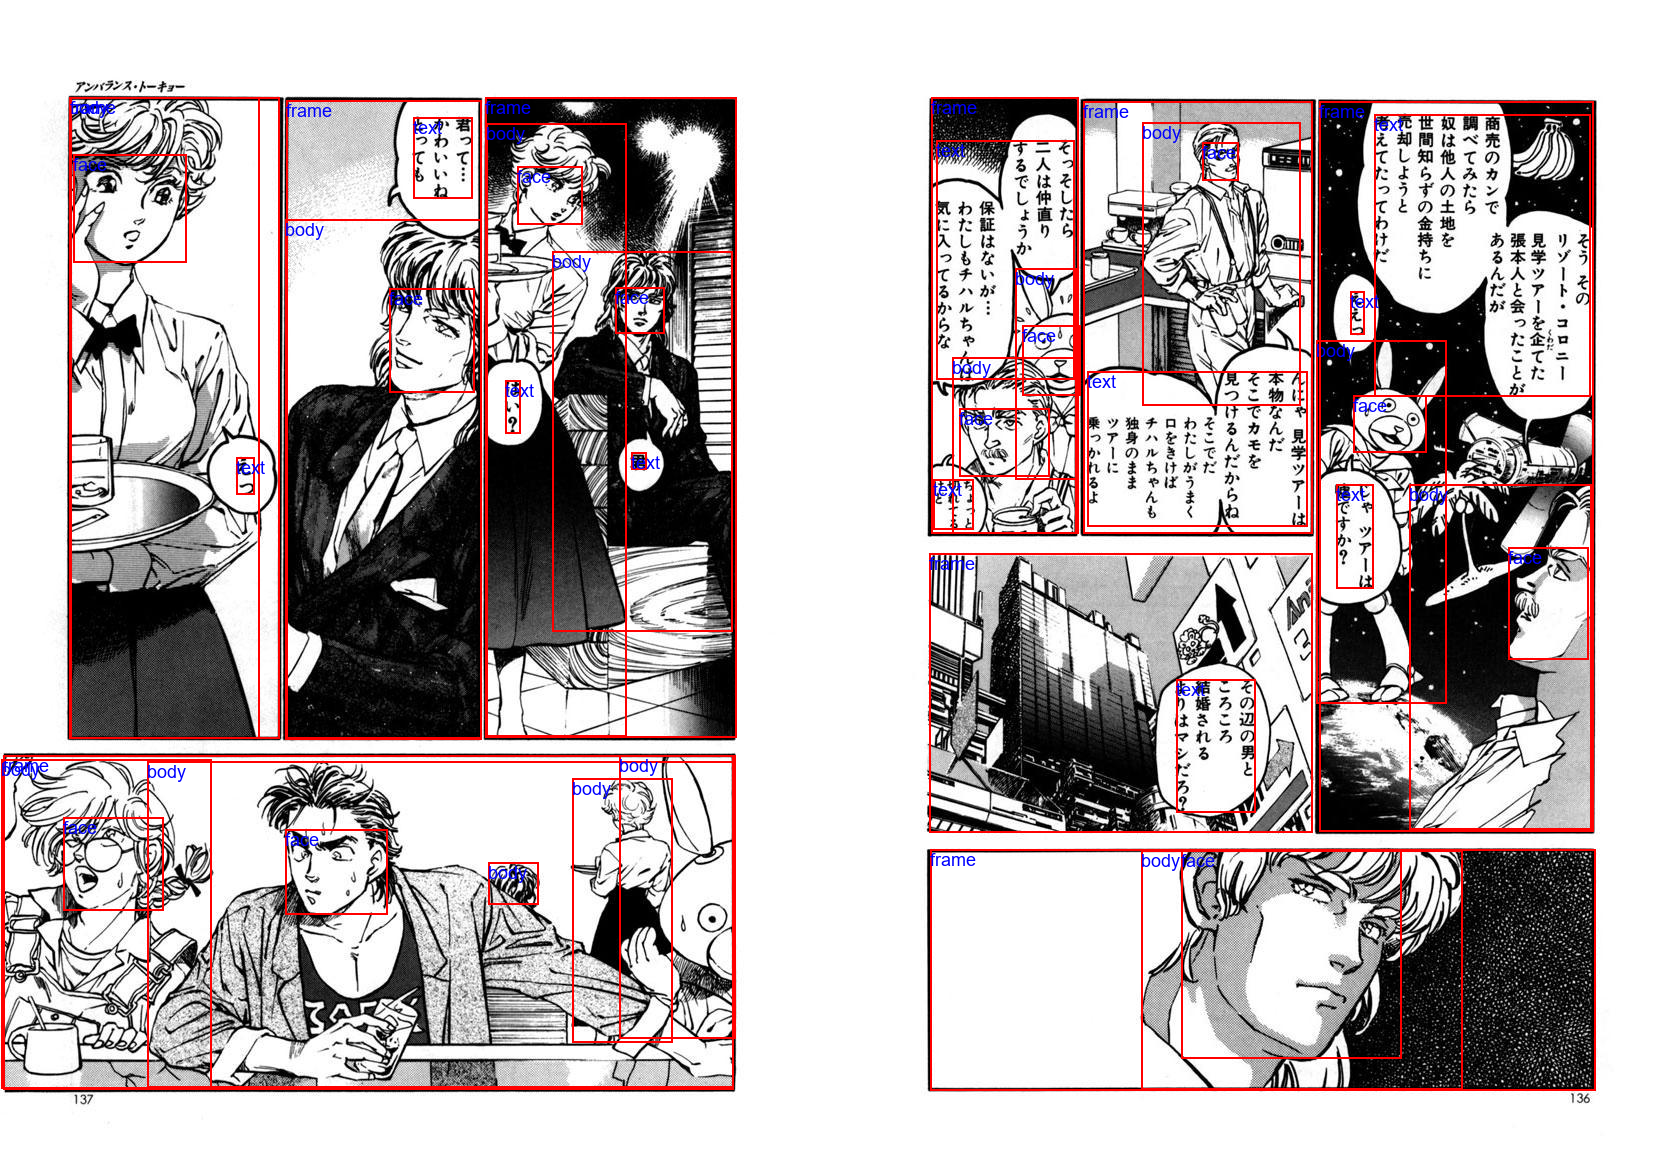

In [250]:
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()

# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
# image_id = image_ids[17]
# print(f'image_id: {image_id}')

print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
# print(f'image: {image}')

image = Image.open(os.path.join(TRAIN_DIRECTORY, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
print(f'annotations: {annotations}')
print(f'annotations: {len(annotations)}')

font = ImageFont.truetype("arial.ttf", size=18)
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=2)
    draw.text((x, y), id2label[class_idx], fill='blue', font=font)

image

In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [8]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [9]:
pixel_values, target = train_dataset[0]

In [10]:
pixel_values.shape

torch.Size([3, 800, 1130])

In [11]:
print(target)

{'size': tensor([ 800, 1130]), 'image_id': tensor([0]), 'class_labels': tensor([], dtype=torch.int64), 'boxes': tensor([], size=(0, 4)), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64), 'orig_size': tensor([1170, 1654])}


## 2. Train the model using PyTorch Lightning

In [12]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [13]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 1732), started 5:11:54 ago. (Use '!kill 1732' to kill it.)

In [14]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
outputs.logits.shape

torch.Size([4, 100, 5])

## Start training:

In [16]:
import torch
print(torch.cuda.is_available())  

True


In [17]:
# from pytorch_lightning import Trainer

# # trainer = Trainer(accelerator='gpu', max_steps=300, gradient_clip_val=0.1)
# trainer = Trainer(
#     accelerator='gpu',
#     max_epochs=20,            
#     limit_train_batches=1.0,    
#     limit_val_batches=1.0,      
#     gradient_clip_val=0.1,     
#     logger=None,          
#     callbacks=None,     
#     enable_checkpointing=True    
# )
# trainer.fit(model)

## Push to Hub

In [18]:
# !huggingface-cli login

In [19]:
# model.model.push_to_hub("zehdi02/detr_manga109")
# processor.push_to_hub("zehdi02/detr_manga109")

## Reload model from Hub

In [218]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

model = DetrForObjectDetection.from_pretrained("zehdi02/detr_manga109", id2label={0:'face', 1:'body', 2:'text', 3:'frame'})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = DetrImageProcessor.from_pretrained("zehdi02/detr_manga109")

## 3. Evaluate model

In [219]:
# !pip install -q coco-eval

In [220]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [221]:
# Make sure model is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

## Start Evaluation:

In [222]:
# from coco_eval import CocoEvaluator
# from tqdm.notebook import tqdm
# import numpy as np

# # initialize evaluator with ground truth (gt)
# evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

# # Run the evaluation
# print("Running evaluation...")
# for idx, batch in enumerate(tqdm(val_dataloader)):
#     # Get the inputs and move them to the correct device
#     pixel_values = batch["pixel_values"].to(device)
#     pixel_mask = batch["pixel_mask"].to(device)
#     labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]  # Move labels to GPU

#     # Forward pass
#     with torch.no_grad():
#         outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

#     # Post-process the outputs
#     orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
#     results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

#     # Prepare predictions for evaluation
#     predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
#     predictions = prepare_for_coco_detection(predictions)
#     evaluator.update(predictions)

# evaluator.synchronize_between_processes()
# evaluator.accumulate()
# evaluator.summarize()


## Inference (+ visualization)

In [326]:
import random

rand_id = np.random.randint(0, len(val_dataset))
print(rand_id)

# pixel_values, target = val_dataset[1]
pixel_values, target = val_dataset[rand_id]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

1311
torch.Size([1, 3, 800, 1130])


In [327]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [328]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=8,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

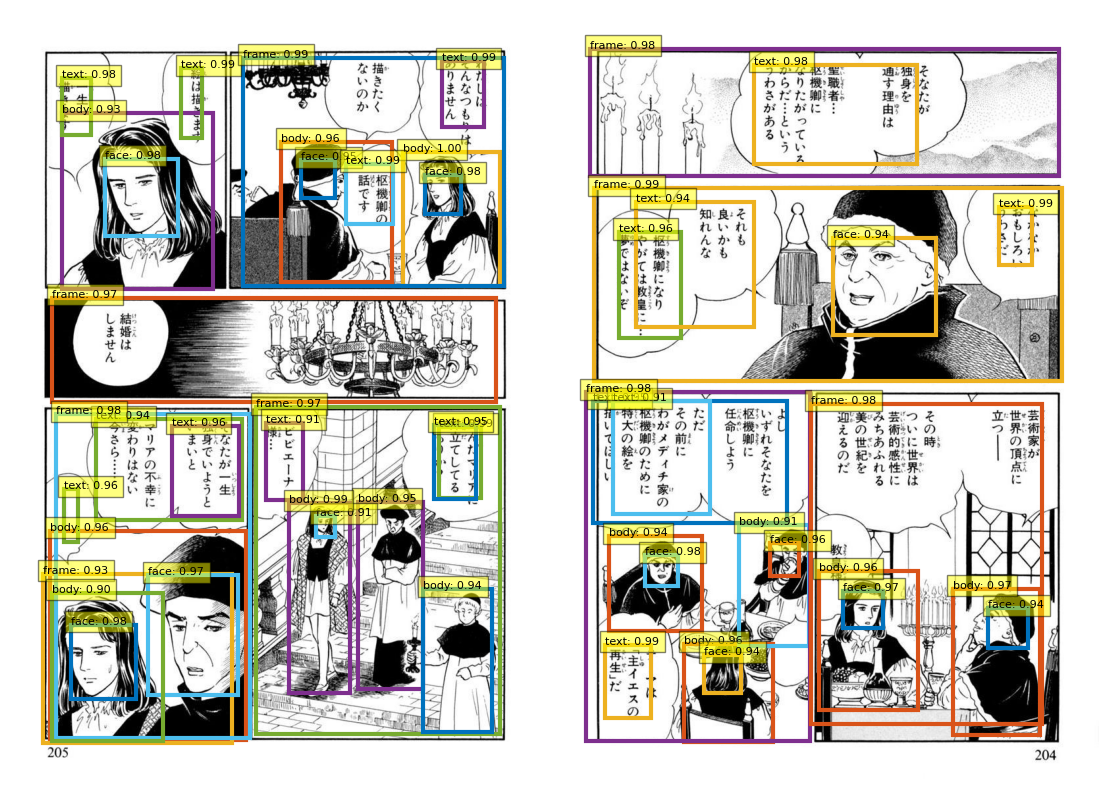

In [329]:
# load image based on ID
image_id = target['image_id'].item()

image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(VAL_DIRECTORY, image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [330]:
print(os.path.join(VAL_DIRECTORY, ANNOTATION_FILE_NAME))

../Manga109/dataset_split\val\annotations.json


In [331]:
import json

def image_id_get_filename_amt(annotations_path, image_id):
    with open(annotations_path, 'r') as f:
        coco_data = json.load(f)

    file_name = None
    annotation_count = 0

    # find file_name associated with the image_id 
    for image in coco_data['images']:
        if image['id'] == image_id:
            file_name = image['file_name']
            break

    # count annotations
    for annotation in coco_data['annotations']:
        if annotation['image_id'] == image_id:
            annotation_count += 1

    return file_name, annotation_count 


print(f'image_id: {rand_id}')

fp_json = os.path.join(VAL_DIRECTORY, ANNOTATION_FILE_NAME)
file_name, annotation_count = image_id_get_filename_amt(fp_json, image_id)

if file_name:
    print(f"file name: {file_name}")
else:
    print(f"image_id {image_id} not found")

print(f"annotations count: {annotation_count}")

print(f'boxes detected: {len(results['boxes'])}')

image_id: 1311
file name: Raphael_64102.jpg
annotations count: 55
boxes detected: 51


In [332]:
torch.cuda.empty_cache()

In [333]:
import torch
print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU Memory Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
print(f"GPU Memory Available: {torch.cuda.memory_reserved() - torch.cuda.memory_allocated() / 1024**3:.2f} GB")


Total GPU Memory: 6.00 GB
GPU Memory Allocated: 0.81 GB
GPU Memory Reserved: 0.82 GB
GPU Memory Available: 880803839.19 GB
